In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define the convolutional autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4 -> 8x8
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.Sigmoid()  # Output in the range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Prepare CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Test the autoencoder on some test images
model.eval()
test_iter = iter(test_loader)
test_images, _ = next(test_iter)
test_images = test_images.to(device)

with torch.no_grad():
    reconstructed = model(test_images)

# You can visualize the reconstructed images and compare them with the original test images


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/2], Loss: 0.0127
Epoch [2/2], Loss: 0.0045


Original Images


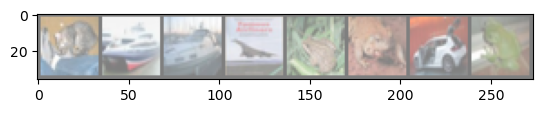

Reconstructed Images


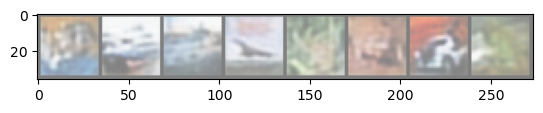

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.cpu().numpy()  # Convert to NumPy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Reorder dimensions for plotting
    if title:
        plt.title(title)
    plt.show()

# Get a batch of test images
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Get the first batch of test images
    test_iter = iter(test_loader)
    test_images, _ = next(test_iter)
    test_images = test_images.to(device)

    # Pass the test images through the autoencoder
    reconstructed_images = model(test_images)

# Visualize original vs reconstructed images
# Choose the number of images to display
num_images = 8

# Plot original images
print("Original Images")
imshow(torchvision.utils.make_grid(test_images[:num_images]))

# Plot reconstructed images
print("Reconstructed Images")
imshow(torchvision.utils.make_grid(reconstructed_images[:num_images]))
